In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

Сценарий:

    - заранее выдвигаем шторку с фонариком и запускаем браузер
    - включаем мониторинг
    - мигаем фонариком пять раз
    - задвигаем шторку, ждем чуть больше минуты
    - жмем на загрузку файла, ждем окончания
    - ждем еще несколько секунд, стопаем мониторинг

Читаем данные из порта USB в файл:

`cat /dev/cu.usbmodem1421 > browser_download.bin`

Они будут в бинарном формате, прочитаем их в DataFrame и сконвертируем в миллиамперы:

In [4]:
df = pd.DataFrame(np.fromfile(
        "./browser_download_lte_wf.bin",
        dtype=np.uint16).astype(np.float32) * (3300 / 2**12))

Группируем по миллисекундам и усредняем:

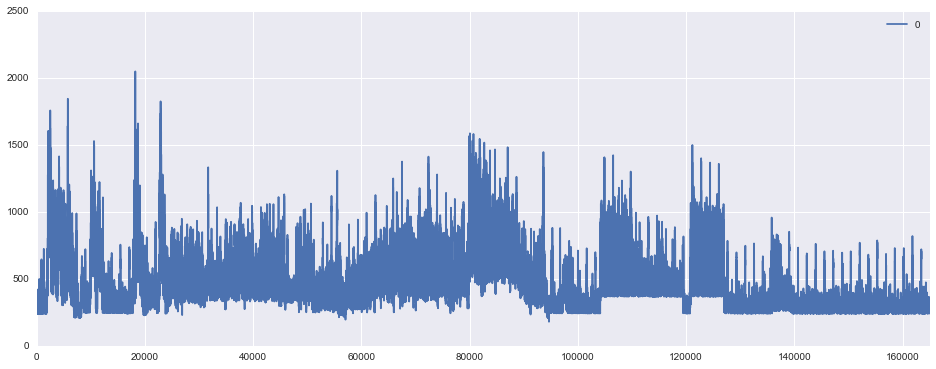

In [5]:
df_r1000 = df.groupby(df.index//1000).mean()
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000.plot(ax=ax)

Интересные нам всплески потребления кончаются где-то на 10000-ной миллисекунде.

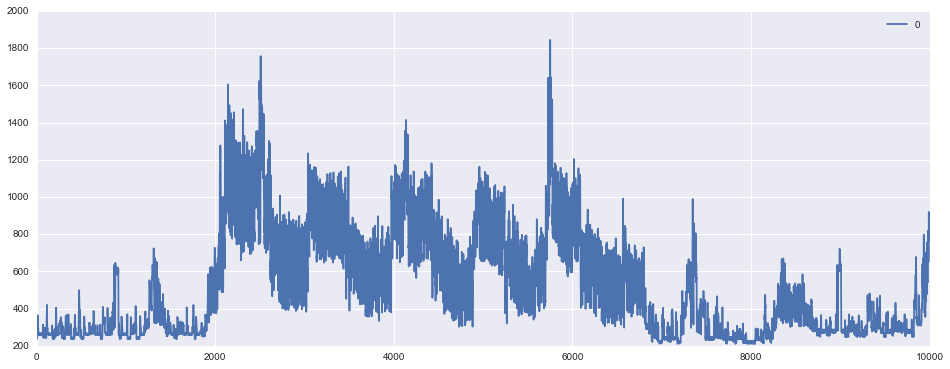

In [6]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[:10000].plot(ax=ax)

Синхронизируемся по 3-му всплеску, кажется, он самый острый:

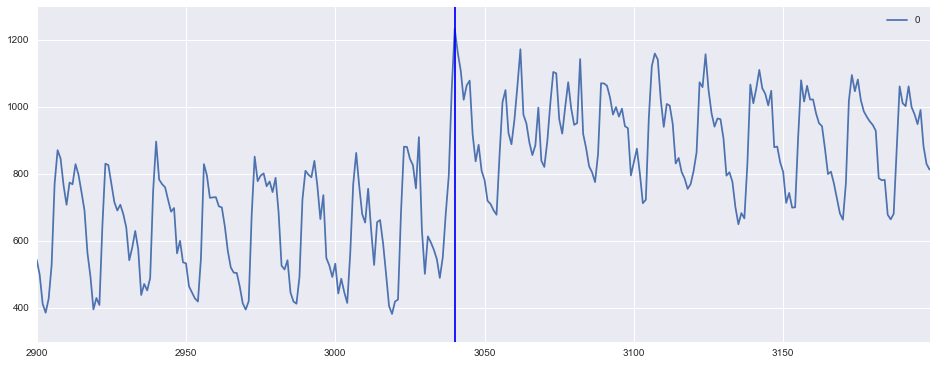

In [11]:
sync = 3040
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[2900:3200].plot(ax=ax)
sns.plt.axvline(sync)


Грузим события из лога (`adb logcat -d |egrep "DownloadTracking|onTorchStatusChanged"`):

In [12]:
from datetime import datetime
with open("browser_download_lte_wf_events.log") as eventlog:
    events = [
        datetime.strptime(
            l.split()[1], "%H:%M:%S.%f")
        for l in eventlog.readlines()]
offsets = [(ev - events[0]).total_seconds() for ev in events]

И построим их на нашем графике:

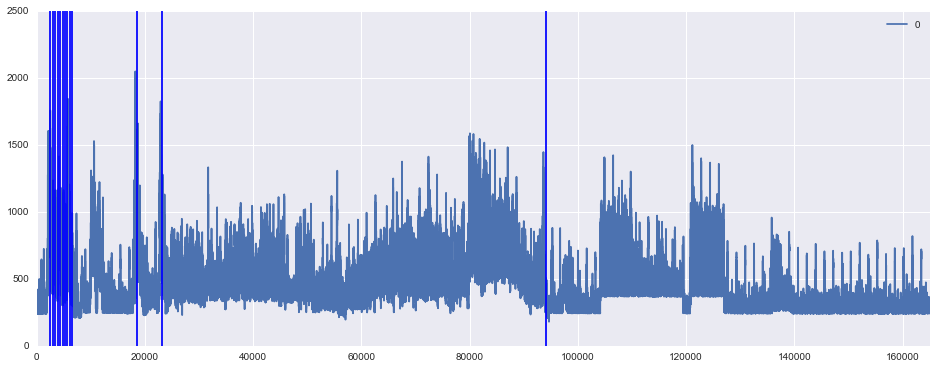

In [13]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000.plot(ax=ax)

for o in offsets:
    sns.plt.axvline(sync + (o - offsets[3]) * 1000)


Seems like ok. Нас интересует idle период в районе 100000 - 160000, там видны всплески потребления и период скачивания -- последние две метки.

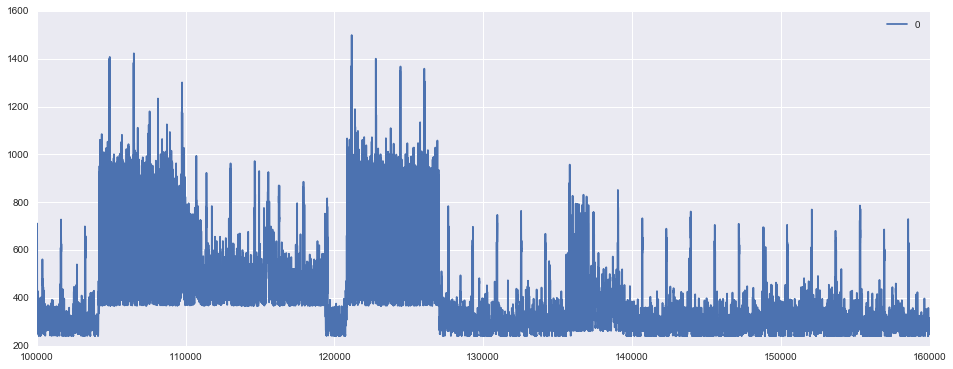

In [14]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[100000:160000].plot(ax=ax)

for o in offsets:
    sns.plt.axvline(sync + (o - offsets[7]) * 1000)

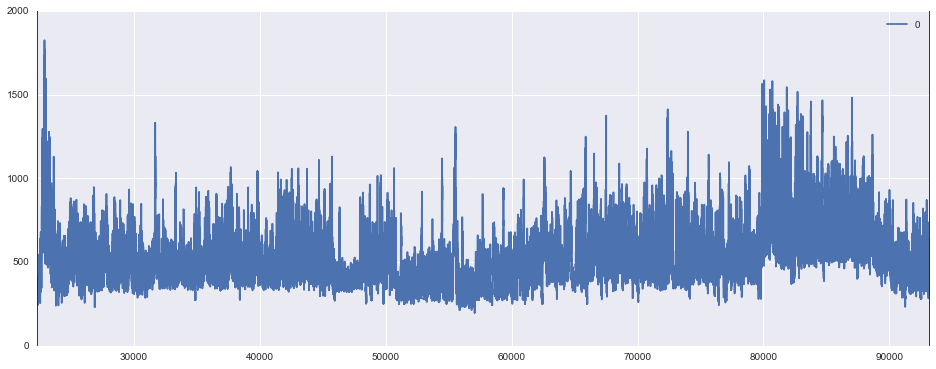

In [15]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[
    int(sync + (offsets[-2] - offsets[5]) * 1000):int(
        sync + (offsets[-1] - offsets[5]) * 1000)].plot(ax=ax)

for o in offsets:
    sns.plt.axvline(sync + (o - offsets[5]) * 1000)

Сравниваем средние:

In [17]:
curr_mean_idle = df_r1000[100000:160000].mean()
curr_mean_download = df_r1000[
    int(sync + (offsets[-2] - offsets[5]) * 1000):int(
        sync + (offsets[-1] - offsets[5]) * 1000)].mean()
print("Среднее значение тока в покое, мА: %.2f" % curr_mean_idle)
print("Среднее значение тока во время загрузки, мА: %.2f" % curr_mean_download)
print("Разница, мА: %.2f" % (curr_mean_download - curr_mean_idle))

Среднее значение тока в покое, мА: 350.59
Среднее значение тока во время загрузки, мА: 504.58
Разница, мА: 154.00
